# Analysis of the sources of energy generation.

### Project description:

This project analyses global data on energy production by fuel type. Historical data are presented and special attention is given to the relationship between bioenergy (biomass) production and afforestation in different countries. Specific questions in these areas are sought to be answered.


### Data Preperation:

Initially, the data is loaded from the CSV files and then only the data that is of interest to the project is extracted and saved as data frames.

In [25]:
# Import libraries that will be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Read raw file, select and rename columns for better readability
historicalData = pd.read_csv('csv/Global_Energy.csv', usecols = ['Entity', 'Year', 'Other renewables (TWh, substituted energy)',
'Biofuels (TWh, substituted energy)', 'Solar (TWh, substituted energy)', 'Wind (TWh, substituted energy)', 'Hydropower (TWh, substituted energy)',
'Nuclear (TWh, substituted energy)', 'Gas (TWh, substituted energy)', 'Oil (TWh, substituted energy)', 'Coal (TWh, substituted energy)', 
'Traditional biomass (TWh, substituted energy)']).rename(columns={'Entity':'Country', 'Other renewables (TWh, substituted energy)':'Other Renewables',
'Biofuels (TWh, substituted energy)':'Biofuels', 'Solar (TWh, substituted energy)':'Solar', 'Wind (TWh, substituted energy)':'Wind',
'Hydropower (TWh, substituted energy)':'Hydro', 'Nuclear (TWh, substituted energy)':'Nuclear', 'Gas (TWh, substituted energy)':'Gas',
'Oil (TWh, substituted energy)':'Oil', 'Coal (TWh, substituted energy)':'Coal', 'Traditional biomass (TWh, substituted energy)':'Biomass'})

# Read raw file and select columns
energyProductionByCountry = pd.read_csv('csv/Electricity_Production_By_Source.csv', usecols=['Entity', 'Year', 'Electricity from coal (TWh)',
'Electricity from gas (TWh)', 'Electricity from hydro (TWh)', 'Electricity from other renewables (TWh)', 'Electricity from solar (TWh)',
'Electricity from oil (TWh)', 'Electricity from wind (TWh)', 'Electricity from nuclear (TWh)'])

# Read raw file, rename country column, replace unreadable symbols and clear the data frame of unneeded empty values.
energyProductionFromBiomassRaw = pd.read_csv('csv/Energy_From_Biomass.csv')
energyProductionFromBiomass = energyProductionFromBiomassRaw.replace({'♦': '', '^': '', '-': ''}, regex=True)
energyProductionFromBiomass = energyProductionFromBiomass.replace('^', float('nan'))
energyProductionFromBiomass = energyProductionFromBiomass.replace('', np.nan)
energyProductionFromBiomass = energyProductionFromBiomass.rename(columns={'Terawatt-hours': 'Country'})
# Use the latest data as it is the most complete. Convert values from strings to numeric, to allow further operations.
mostRecentFromBiomass = energyProductionFromBiomass[['Country', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006']].dropna()
mostRecentFromBiomass.iloc[:, 1:] = mostRecentFromBiomass.iloc[:, 1:].astype(float)
# Adapt dataset format.
id = ['Country']
value = ['2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006']
# Melt the dataframe to transform the column names into rows
melted_mostRecentFromBiomass = pd.melt(mostRecentFromBiomass, id_vars=id, value_vars=value, var_name='Year', value_name='Value (TWh)')
mostRecentFromBiomass_cleaned = melted_mostRecentFromBiomass.sort_values(["Country", "Year"], ascending=[True, False]).reset_index(drop=True)

# Read raw file and select columns
# Multiply Value and Unit (1000ha) columns to get Total Value and remove unwanted Unit and Value columns
forestCoverageArea = pd.read_csv('csv/Forest_Coverage_Area.csv', usecols=['Area', 'Year', 'Unit', 'Value'])
forestCoverageArea['Total Value (ha)'] = forestCoverageArea.apply(lambda row: row['Value'] * 1000, axis=1)
forestCoverageArea.drop(['Unit', 'Value'], axis=1, inplace=True)

<Axes: title={'center': 'Resource use for energy production worldwide 1800 - 2021'}, xlabel='Year', ylabel='TWh'>

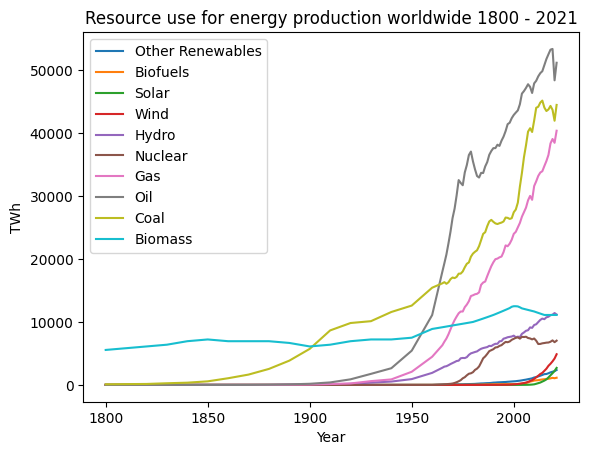

In [26]:
# Show how energy was produced based on historical data

historicalData.plot(x='Year', ylabel='TWh', title='Resource use for energy production worldwide 1800 - 2021')

We can see that initially only Biomass was used, and in the mid-19th century the use of coal was introduced. At the beginning of the 20th century a variety of energy sources began to be used (mainly fossil fuels). Then nuclear and renewable energy were introduced.

The graph above also shows a fairly constant use of biomass (mainly wood).

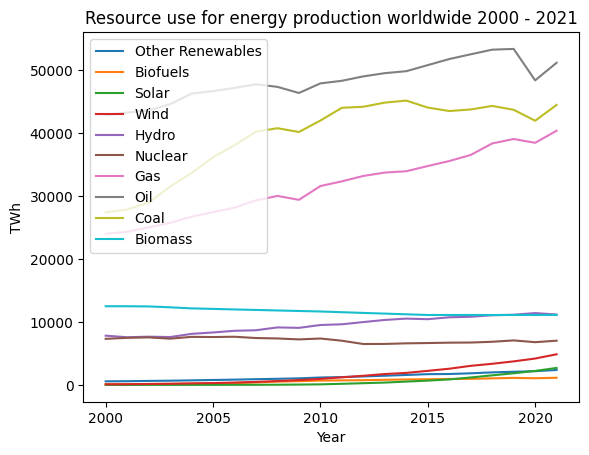

In [27]:
# Let's see how the use of resources has been distributed in recent years.

historicalData_XXI = historicalData.tail(22)

graph = historicalData_XXI.plot(x='Year', ylabel='TWh', title='Resource use for energy production worldwide 2000 - 2021')
graph.legend(loc='upper left')

It can be observed above that, despite the shift in global trends towards renewable energy, coal, oil, and gas continue to be the most widely used.
Let's examine which countries currently utilize these resources the most.

In [28]:
# In order to show the most recent data, the data frame has been filtered to show data from 2019, as later data are much less complete
size_2020 = energyProductionByCountry[(energyProductionByCountry['Year'] == 2020)].size # 71
size_2019 = energyProductionByCountry[(energyProductionByCountry['Year'] == 2019)].size # 235

print('Number of countries in the 2020 set is', size_2020, 'and in 2019 is', size_2019, 'therefore decided to use less recent but more comprehensive data.')

# I decided not to include the World, Continents and Other Major Regions rows,
# but to include the EU27+1 (EU + UK) row, as the UK was still a member of the EU at the time and had 28 members.
exclude_list = ['World', 'EU-27', 'Middle East', 'Asia Pacific', 'Other Middle East', 'Other Asia & Pacific', 'North America', 'South & Central America',
'Africa', 'Europe', 'Europe (other)', 'CIS', 'Other CIS', 'Eastern Africa']

most_recent_data = energyProductionByCountry[(energyProductionByCountry['Year'] == 2019) & (~energyProductionByCountry['Entity'].isin(exclude_list))]

Number of countries in the 2020 set is 710 and in 2019 is 2350 therefore decided to use less recent but more comprehensive data.


But first lets take a visualisation of the distribution of power sources in a pie chart.

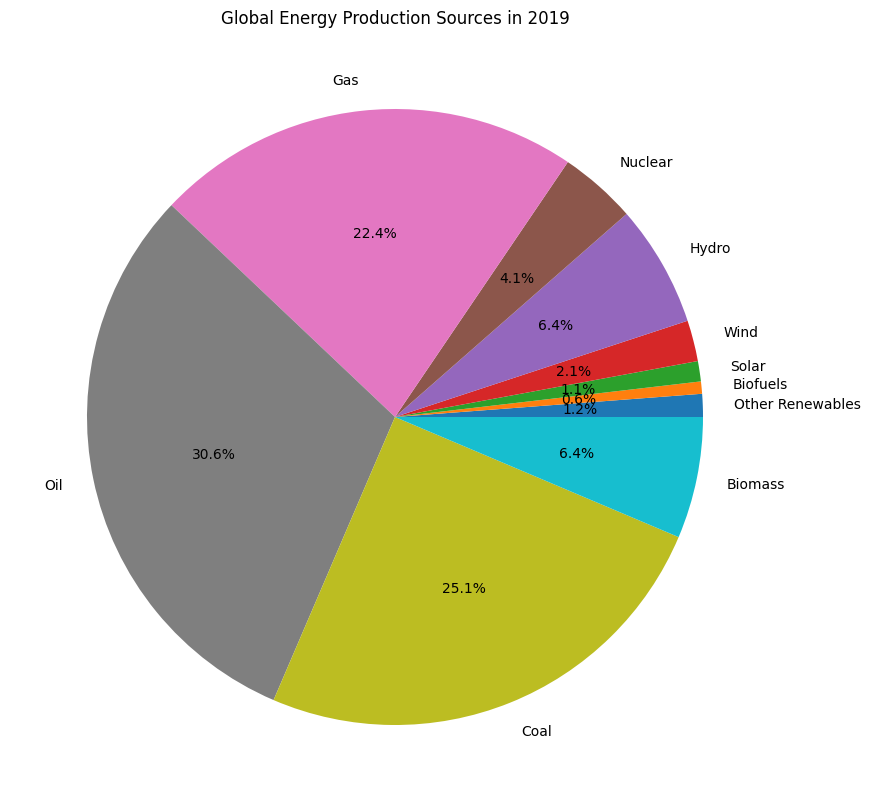

In [29]:
# Filter the data for the year 2019
powerSourcesDist_2019 = historicalData[historicalData['Year'] == 2019]

# Create a new DataFrame with the sum of renewable energy sources for each country
sources = powerSourcesDist_2019[['Country', 'Other Renewables', 'Biofuels', 'Solar', 'Wind', 'Hydro', 'Nuclear', 'Gas', 'Oil', 'Coal', 'Biomass']]
sources_sum = sources.groupby('Country').sum()

# Create a pie chart for the renewable energy sources in 2019
plt.figure(figsize=(10, 10))
plt.pie(sources_sum.sum(), labels=sources_sum.columns, autopct='%1.1f%%')
plt.title('Global Energy Production Sources in 2019')
plt.show()

Graphic representation of the 20 most fossil fuel-consuming economies.

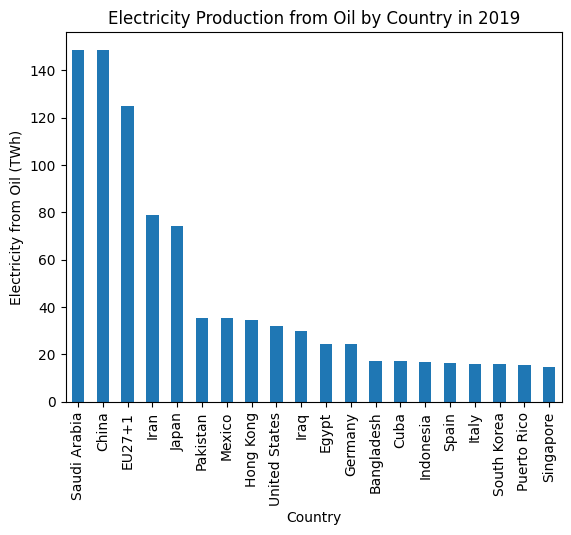

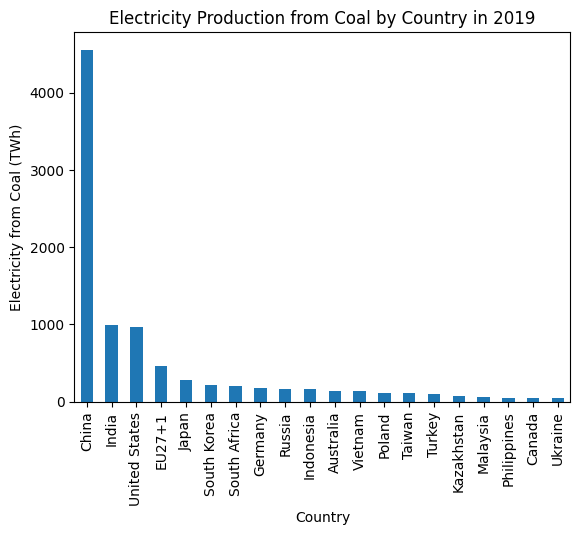

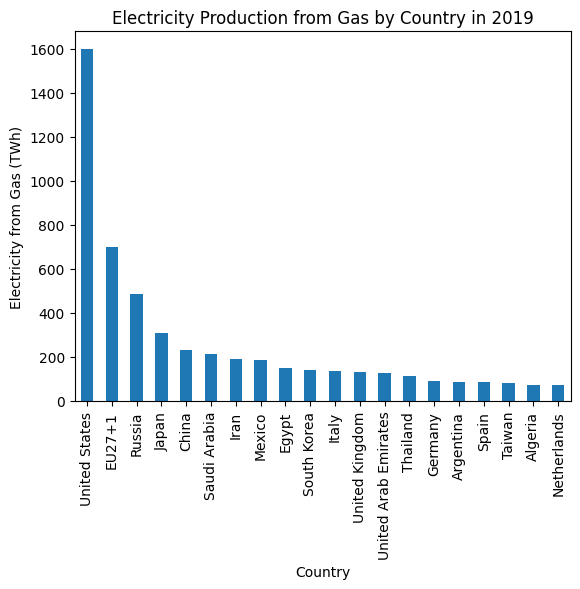

In [30]:
# sort the values by electricity from oil column
oil_usage = most_recent_data.sort_values('Electricity from oil (TWh)', ascending=False)

# plot the data
oil_usage.head(20).plot(x='Entity', y='Electricity from oil (TWh)', kind='bar', legend=False)

# set the title and axis labels
plt.title('Electricity Production from Oil by Country in 2019')
plt.xlabel('Country')
plt.ylabel('Electricity from Oil (TWh)')
plt.show()

# electricity from coal
coal_usage = most_recent_data.sort_values('Electricity from coal (TWh)', ascending=False)
coal_usage.head(20).plot(x='Entity', y='Electricity from coal (TWh)', kind='bar', legend=False)
plt.title('Electricity Production from Coal by Country in 2019')
plt.xlabel('Country')
plt.ylabel('Electricity from Coal (TWh)')
plt.show()


# electricity from gas
gas_usage = most_recent_data.sort_values('Electricity from gas (TWh)', ascending=False)
gas_usage.head(20).plot(x='Entity', y='Electricity from gas (TWh)', kind='bar', legend=False)
plt.title('Electricity Production from Gas by Country in 2019')
plt.xlabel('Country')
plt.ylabel('Electricity from Gas (TWh)')
plt.show()

In comparison, let's see which economies produce the most energy from the two most popular renewable resources.

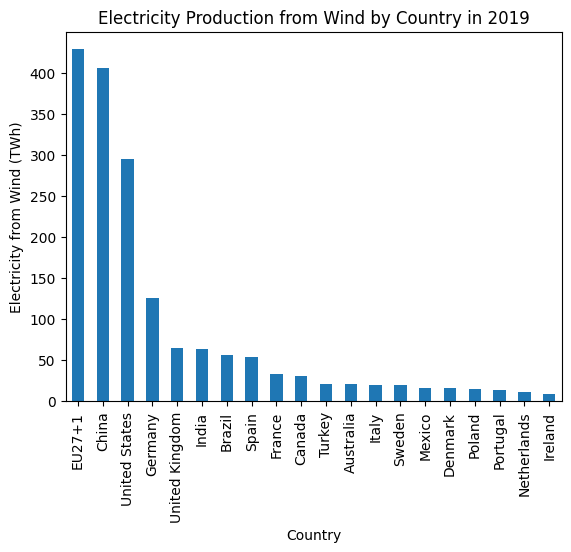

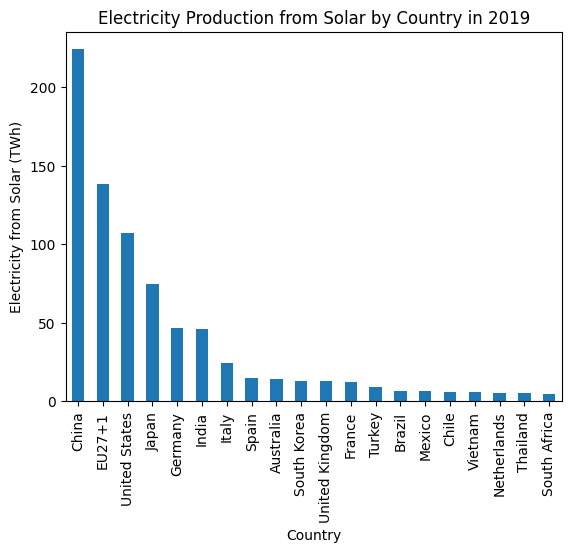

In [31]:
# electricity from wind
wind_energy = most_recent_data.sort_values('Electricity from wind (TWh)', ascending=False)
wind_energy.head(20).plot(x='Entity', y='Electricity from wind (TWh)', kind='bar', legend=False)
plt.title('Electricity Production from Wind by Country in 2019')
plt.xlabel('Country')
plt.ylabel('Electricity from Wind (TWh)')
plt.show()

# electricity from solar
solar_energy = most_recent_data.sort_values('Electricity from solar (TWh)', ascending=False)
solar_energy.head(20).plot(x='Entity', y='Electricity from solar (TWh)', kind='bar', legend=False)
plt.title('Electricity Production from Solar by Country in 2019')
plt.xlabel('Country')
plt.ylabel('Electricity from Solar (TWh)')
plt.show()

The ratio of solar and wind power is also shown below according to historical data, where large-scale wind turbines started to be installed in the late 1970s and solar panels began to be used in the 1980s.

Text(0, 0.5, 'TWh')

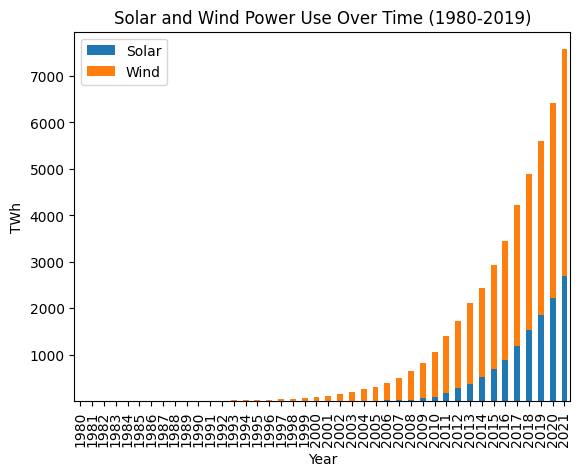

In [32]:
wind_and_solar = historicalData[historicalData['Year']>=1980].groupby('Year').sum()[['Solar', 'Wind']]
wind_and_solar.plot(kind='bar', stacked=True)
plt.title('Solar and Wind Power Use Over Time (1980-2019)')
plt.ylabel('TWh')

Now, the analysis of the utilization of wood for energy generation will be undertaken. As indicated above, this form of energy has been consistently employed at a comparable level for numerous years.
Examining the countries that predominantly utilize wood for energy and those with substantial forest resources becomes imperative. It is essential to determine whether the abundance of forest resources correlates with the quantity of power produced using this raw material.
The investigation will also attempt to predict whether the availability of forest resources is currently reflected in the current levels of power production using this specific raw material. This predictive analysis can offer insights into the sustainability and feasibility of wood as an energy source in the present scenario.

It should be noted that plants account for about 82% of the biomass components. (https://www.visualcapitalist.com/all-the-biomass-of-earth-in-one-graphic/)

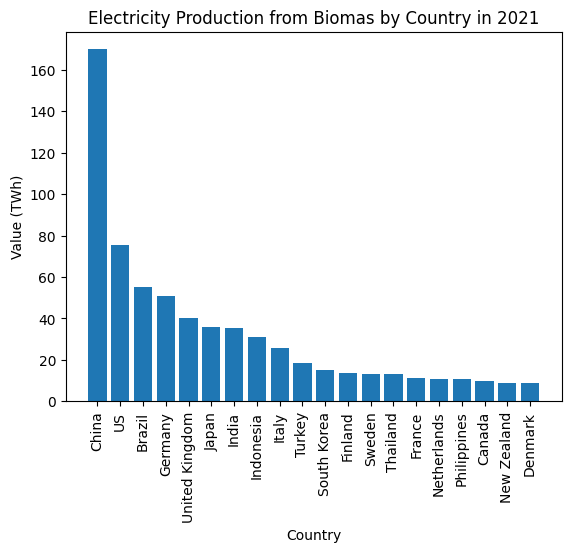

In [33]:
# I decided not to include the World, Continents and Other Major Regions rows. I also had to use the str.strip() function to remove leading/trailing white space still present in data
exclude_list = ['Total World', 'of which: OECD', 'NonOECD', 'Total Asia Pacific', 'Total Europe', 'European Union #', 'Total North America', 'Total S. & Cent. America', 'Central America']
mostRecentFromBiomass_cleaned['Country'] = mostRecentFromBiomass_cleaned['Country'].str.strip()
mostRecentPowerFromBiomass_cleaned = mostRecentFromBiomass_cleaned[(mostRecentFromBiomass_cleaned['Year'] == '2021') & (~mostRecentFromBiomass_cleaned['Country'].isin(exclude_list))].sort_values('Value (TWh)', ascending=False).head(20)

plt.bar(mostRecentPowerFromBiomass_cleaned['Country'], mostRecentPowerFromBiomass_cleaned['Value (TWh)'])
plt.xlabel('Country')
plt.ylabel('Value (TWh)')
plt.title('Electricity Production from Biomas by Country in 2021')
plt.xticks(rotation=90)
plt.show()

Now let's see which countries have the most forests.

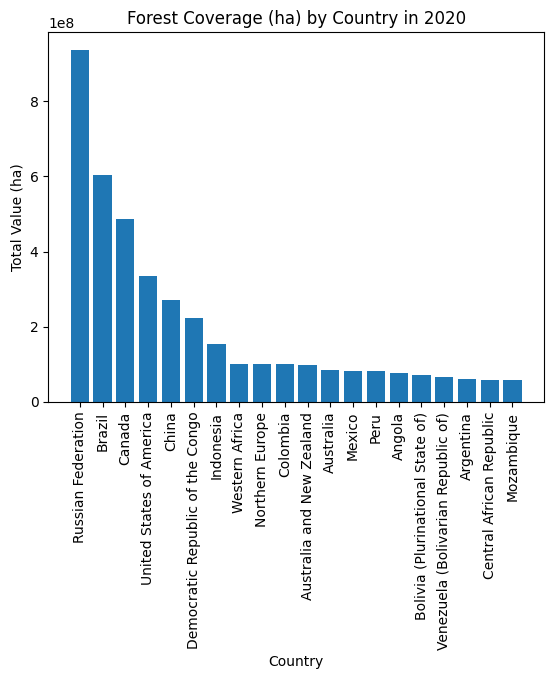

In [34]:
# I decided not to include the World, Continents and Other Major Regions rows.
exclude_list = ['World', 'Americas', 'Europe', 'South America', 'Net Food Importing Developing Countries', 'Eastern Europe', 
'Net Food Importing Developing Countries', 'South America', 'Africa', 'Northern America', 'Least Developed Countries', 'Low Income Food Deficit Countries', 'Asia',
'Middle Africa', 'Land Locked Developing Countries', 'South-eastern Asia', 'Eastern Asia', 'Land Locked Developing Countries', 'China, mainland', 'Eastern Africa',
'Eastern Asia', 'European Union (27)', 'Oceania', 'Central America', 'Small Island Developing States', 'Southern Asia']

forestCoverageArea_cleaned = forestCoverageArea[(forestCoverageArea['Year'] == 2020) & (~forestCoverageArea['Area'].isin(exclude_list))]

forestCoverageArea_cleaned = forestCoverageArea_cleaned.sort_values(by='Total Value (ha)', ascending=False).drop_duplicates(subset='Area')
forestCoverageArea_cleaned = forestCoverageArea_cleaned.head(20)
plt.bar(forestCoverageArea_cleaned['Area'], forestCoverageArea_cleaned['Total Value (ha)'])
plt.xticks(rotation='vertical')
plt.xlabel('Country')
plt.ylabel('Total Value (ha)')
plt.title('Forest Coverage (ha) by Country in 2020')
plt.show()


Now let's examine the relationship between the level of forest cover and the use of biomass for energy production.

Using linear regression, we will try to predict how much energy is, or can be generated from biomass based on the amount of forest cover. 

It should be noted that we are not looking here at wood-burning efficiency, but at the relationship between the availability of forest resources and the generation of energy using these resources as a energy source.

In [35]:
forestCoverage = forestCoverageArea[(forestCoverageArea['Year'] == 2020) & (~forestCoverageArea['Area'].isin(exclude_list))]
forestCoverage = forestCoverage.rename(columns={"Area": "Country"})
powerFromBiomass = mostRecentFromBiomass_cleaned[(mostRecentFromBiomass_cleaned['Year'] == '2020') & (~mostRecentFromBiomass_cleaned['Country'].isin(exclude_list))].sort_values('Value (TWh)', ascending=False)

# merge the two datasets on the 'Country' column
forest_vs_biomass = pd.merge(forestCoverage, powerFromBiomass, on='Country', how='left').dropna()
forest_vs_biomass['Value (TWh)'] = pd.to_numeric(forest_vs_biomass['Value (TWh)'], errors='coerce')

# train a linear regression model to predict biomass electricity generation based on forest cover
X = forest_vs_biomass['Total Value (ha)'].values.reshape(-1, 1)
y = forest_vs_biomass['Value (TWh)'].values.reshape(-1, 1)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# train a linear regression model to predict biomass electricity generation based on forest cover
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# make a prediction for 10 million hectares of forest cover
forest_cover = 10000000
electricity_generated = regressor.predict([[forest_cover]])
print(f'Forest cover: {forest_cover} ha\nPredicted biomass electricity generation: {electricity_generated[0][0]:.2f} TWh')

# test the model on the test set
y_pred = regressor.predict(X_test)

# evaluate the model using mean squared error

mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

Forest cover: 10000000 ha
Predicted biomass electricity generation: 10.63 TWh
Mean squared error: 256.1984357753884


The above results indicates a moderate to high level of error, as a mean squared error of 256.2 is about 16 TWh, and the model used to forecast biomas electricity generation might have some limitations or inaccuracies, so it must be assumed that another value should be used to improve the accuracy of the model. This could also mean that there is a weak correlation between forest cover and predicted biomass energy generation, meaning that changes in forest cover have little impact on predicted biomass energy generation. This low correlation suggests that there are many other factors that influence biomass energy generation and that forest cover is not the main determinant of this generation.

Let's see how it looks on the chart, where we can observe that the deviations from the line are substantial.

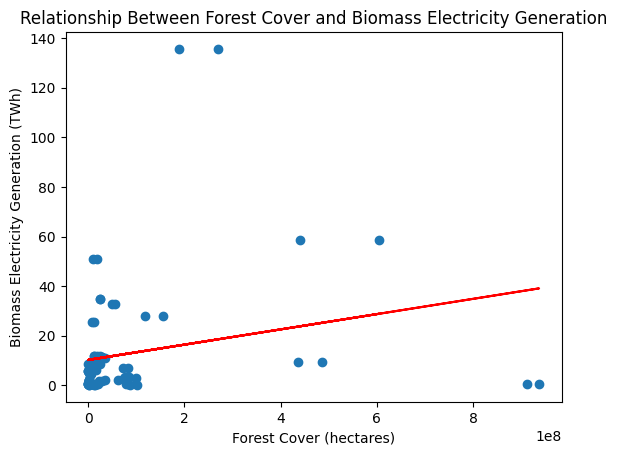

In [36]:
plt.scatter(x='Total Value (ha)', y='Value (TWh)', data=forest_vs_biomass)
x = forest_vs_biomass['Total Value (ha)']
y = forest_vs_biomass['Value (TWh)']
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x, poly1d_fn(x), color='red')
plt.xlabel('Forest Cover (hectares)')
plt.ylabel('Biomass Electricity Generation (TWh)')
plt.title('Relationship Between Forest Cover and Biomass Electricity Generation')
plt.show()

In attempting another application of machine learning prediction tools, the exploration of utilizing an ARIMA model for predicting energy production in Ireland in the upcoming years is underway. The dataset for this model will encompass the years 2000-2020, as they contain comprehensive data for all power sources in Ireland.

Before delving into the prediction process, it is helpful to visually examine the trends in the ratio of consumption of individual resources. Graphical representation will provide insights into the direction of changes in the consumption patterns over the specified period.

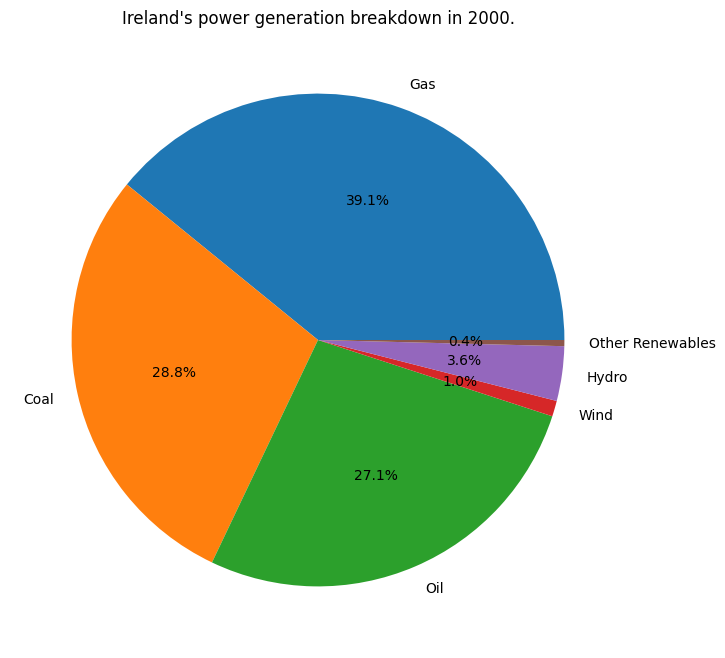

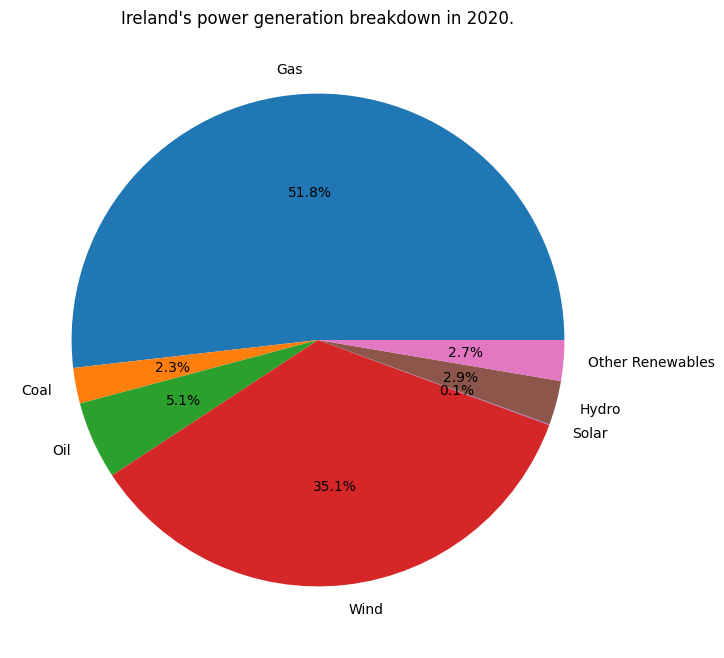

In [37]:
# Select the energy production data for Ireland from the year 2000 onwards.
ireland_power = energyProductionByCountry[(energyProductionByCountry['Entity'] == 'Ireland') & (energyProductionByCountry['Year'] >= 2000)]
ireland_power_2000 = ireland_power[(ireland_power['Entity'] == 'Ireland') & (ireland_power['Year'] == 2000)]

# Extract the electricity generation values por the pie chart. Columns with only 0 values have been ignored.
columns = ireland_power_2000[['Electricity from gas (TWh)','Electricity from coal (TWh)',  'Electricity from oil (TWh)', 'Electricity from wind (TWh)', 'Electricity from hydro (TWh)', 'Electricity from other renewables (TWh)']].values.tolist()[0]

# Create a list of labels for the pie chart
labels = ['Gas', 'Coal', 'Oil', 'Wind', 'Hydro', 'Other Renewables']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(columns, labels=labels, autopct='%1.1f%%')
plt.title("Ireland's power generation breakdown in 2000.")
plt.show()

# Create the same chart for 2020
ireland_power_2020 = ireland_power[(ireland_power['Entity'] == 'Ireland') & (ireland_power['Year'] == 2020)]

columns = ireland_power_2020[['Electricity from gas (TWh)', 'Electricity from coal (TWh)', 'Electricity from oil (TWh)', 'Electricity from wind (TWh)', 'Electricity from solar (TWh)', 'Electricity from hydro (TWh)', 'Electricity from other renewables (TWh)']].values.tolist()[0]
labels = ['Gas', 'Coal', 'Oil', 'Wind', 'Solar', 'Hydro', 'Other Renewables']
plt.figure(figsize=(8, 8))
plt.pie(columns, labels=labels, autopct='%1.1f%%')
plt.title("Ireland's power generation breakdown in 2020.")
plt.show()

It can be seen that Ireland, aligning with global trends, is currently investing in renewables, particularly wind turbines, and distancing itself from coal and oil. Let's now examine what the future holds for wind power generation in Ireland over the next few years

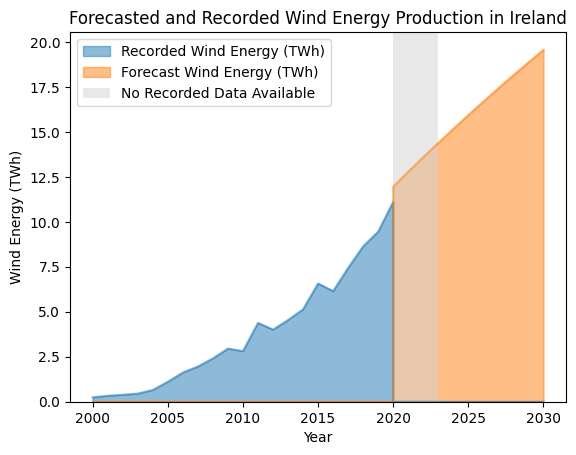

In [38]:
import warnings
warnings.filterwarnings("ignore")

# Define the training data.
train_data = ireland_power[ireland_power['Year'] <= 2020]

# Pivot the data to create a time series and fill missing values by propagating last valid observation forward.
train_pivot = train_data.pivot(index='Year', columns='Entity', values='Electricity from wind (TWh)')
train_pivot = train_pivot.fillna(method='ffill')

# Create an ARIMA model with order (1, 1, 1).
model = ARIMA(train_pivot, order=(1, 1, 1))

# Fit the model to the data.
model_fit = model.fit()

# Forecast future values for 11 years.
future_values = model_fit.forecast(steps=11)

# Create dataset containing the historical and forecasted data
forcastedWind = pd.DataFrame({'Year': range(2020, 2031), 'Forecasted Wind Energy (TWh)': future_values}, columns=['Year', 'Forecasted Wind Energy (TWh)'])
combined_data = pd.concat([train_pivot, forcastedWind.set_index('Year')])

# Create an area chart
ax = combined_data.plot(kind='area', stacked=False)

# Add shaded rectangles at the years with no data
ax.axvspan(2020, 2023, facecolor='lightgray', alpha=0.5, label='No Recorded Data Available')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Wind Energy (TWh)')
plt.title('Forecasted and Recorded Wind Energy Production in Ireland')

# Add legend
handles, labels = ax.get_legend_handles_labels()
labels = ['Recorded Wind Energy (TWh)', 'Forecast Wind Energy (TWh)', 'No Recorded Data Available']
handles = handles[:2] + [plt.Rectangle((0, 0), 1, 1, fc='lightgray', alpha=0.5)]
ax.legend(handles=handles, labels=labels)

warnings.filterwarnings("default")

## Conclusion

This project sets the foundation for ongoing analysis, work, and attempts to predict energy production or source ratios, among other statistical information, utilizing available machine learning tools. Shifting focus from production, future analyses could consider energy consumption or integrate additional factors such as population size or geographical location. A major challenge encountered was data preparation, consuming a significant portion of the project's time. However, this process provided valuable insights into the complexities of modern data analysis. The abundance of available data facilitated analysis but demanded sound knowledge and meticulous data preparation.

An undeniable difficulty arose when obtaining data from earlier periods, often presenting incomplete information and requiring extensive reformatting. Another complicating factor affecting all power production forecasts was recent global turbulence, including the pandemic, the war in Ukraine, and geopolitical events. Additionally, environmental degradation impacted raw material sources for energy production, emphasizing the need to shift towards renewable sources and reduce dependence on uncertain suppliers.

Consequently, when comparing predicted data with future actual data, it may reveal overlooked factors or outdated assumptions. Nonetheless, the field of energy generation explored through this project is exceptionally interesting and worthy of further analysis and prediction, whether for entertainment, scientific exploration, or professional purposes.

Sources of raw data:

https://www.kaggle.com/code/gideonworks/renewable-energy-analysis

https://www.kaggle.com/datasets/programmerrdai/renewable-energy

https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy/downloads.html

https://www.fao.org/faostat/en/#search/forest%20cover%20by%20country

https://www.visualcapitalist.com/all-the-biomass-of-earth-in-one-graphic/